<a href="https://colab.research.google.com/github/skaty5678/face_recognition/blob/main/faceid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib


     |████████████████████████████████| 394.3 MB 15 kB/s 
     |████████████████████████████████| 394.3 MB 16 kB/s 
     |████████████████████████████████| 14.8 MB 29.4 MB/s 
     |████████████████████████████████| 132 kB 9.6 MB/s 
     |████████████████████████████████| 3.8 MB 59.2 MB/s 
     |████████████████████████████████| 462 kB 69.5 MB/s 
     |████████████████████████████████| 2.9 MB 48.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68711 sha256=21594aeb429506d7d22586cc434884d805a88b7434983e8386151496dc94bc81
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:

In [ ]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Setup paths
POS_PATH = '/content/drive/MyDrive/data/positive'
NEG_PATH = '/content/drive/MyDrive/data/negative'
ANC_PATH = '/content/drive/MyDrive/data/anchor'

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*').take(300)

In [ ]:
dir_test = anchor.as_numpy_iterator()


In [ ]:
print(dir_test.next())


b'/content/drive/MyDrive/data/anchor/17467cc2-cc9e-11ec-8297-1094bbdfb49c.jpg'


In [ ]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [ ]:
img = preprocess('/content/drive/MyDrive/data/anchor/17467cc2-cc9e-11ec-8297-1094bbdfb49c.jpg')


In [ ]:
img.numpy().max() 


1.0

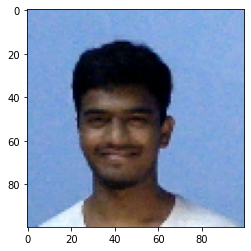

In [ ]:
plt.imshow(img)


In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()


In [ ]:
exampple = samples.next()


In [ ]:
exampple


(b'/content/drive/MyDrive/data/anchor/053cd346-cc9e-11ec-8297-1094bbdfb49c.jpg',
 b'/content/drive/MyDrive/data/positive/73d2121c-cc9e-11ec-8297-1094bbdfb49c.jpg',
 1.0)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*exampple)


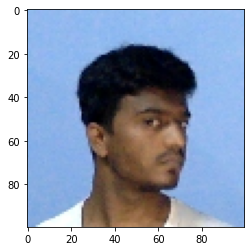

In [ ]:
plt.imshow(res[1])


In [ ]:
res[2]


1.0

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()


In [ ]:
embedding.summary()


Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


In [ ]:
l1 = L1Dist()


In [ ]:
l1

In [ ]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()


In [ ]:
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [ ]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001


In [ ]:
checkpoint_dir = '/content/drive/MyDrive/data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 50


In [ ]:
train(train_data, EPOCHS)



 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 17s 196ms/step

 Epoch 2/50
27/27 [==============================] - 5s 186ms/step

 Epoch 3/50
27/27 [==============================] - 5s 188ms/step

 Epoch 4/50
27/27 [==============================] - 5s 189ms/step

 Epoch 5/50
27/27 [==============================] - 5s 189ms/step

 Epoch 6/50
27/27 [==============================] - 5s 190ms/step

 Epoch 7/50
27/27 [==============================] - 5s 190ms/step

 Epoch 8/50
27/27 [==============================] - 5s 191ms/step

 Epoch 9/50
27/27 [==============================] - 5s 192ms/step

 Epoch 10/50
27/27 [==============================] - 5s 192ms/step

 Epoch 11/50
27/27 [==============================] - 5s 196ms/step

 Epoch 12/50
27/27 [==============================] - 5s 192ms/step

 Epoch 13/50
27/27 [=====

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[5.3717153e-10],
       [4.4903942e-10],
       [2.4266138e-09],
       [4.5481677e-08],
       [1.0000000e+00],
       [1.3966827e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.2858313e-10],
       [9.9999988e-01],
       [9.9999988e-01],
       [1.0000000e+00],
       [5.1191438e-09],
       [9.2542862e-10],
       [9.9999881e-01],
       [9.9999976e-01]], dtype=float32)

In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]

In [ ]:
y_true

array([0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

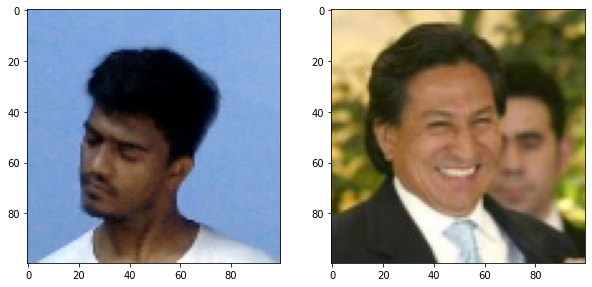

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()


In [ ]:
# Save weights
siamese_model.save('/content/drive/MyDrive/data/siamesemodel.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/data/siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist,
                                                   'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
#make predictions with reloaded model
model.predict([test_input,test_val])

array([[5.3717153e-10],
       [4.4903942e-10],
       [2.4266138e-09],
       [4.5481677e-08],
       [1.0000000e+00],
       [1.3966827e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.2858313e-10],
       [9.9999988e-01],
       [9.9999988e-01],
       [1.0000000e+00],
       [5.1191438e-09],
       [9.2542862e-10],
       [9.9999881e-01],
       [9.9999976e-01]], dtype=float32)

In [ ]:
#view model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     